# Parallel Multistart fitting example

Practical EIS and 2nd-NLEIS analysis can often require fitting complex models with many parameters. This can be computationally expensive and prone to getting stuck in local minima. The `nleis.parallel` module provides a convenient way to perform multistart fitting using multiple CPU cores to speed up the process. This example demonstrates how to use the `parallel` module to fit a complex circuit model to synthetic EIS and 2nd-NLEIS data.

The core function in the `parallel` module is `multistart_fit`, which takes a initialized circuit model, frequency data, EIS data, 2nd-NLEIS data or both as inputs, along with options for the number of starting points and CPU cores to use. It returns the best-fit parameters and the corresponding model predictions. That's said, the `multistart_fit` is also compatiable with impedance.py natively. For detialed documentation, please refer to the [API reference](https://nleispy.readthedocs.io/en/latest/).

## 1. Using multistart_fit for EIS fitting with impedance.py

We first demonstrate the use of `multistart_fit` for fitting EIS data using a simple RC circuit model from impedance.py. We generate synthetic EIS data with added noise and then fit the model using multiple starting points.

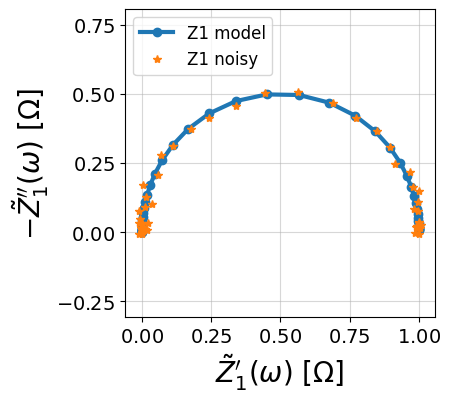

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from impedance.models.circuits import CustomCircuit
from nleis.visualization import plot_first


circuit_1 = "p(R1,C1)"
model_1 = CustomCircuit(circuit_1, initial_guess=[1, 1])

f = np.geomspace(1e-3, 100, 50)
Z1 = model_1.predict(f)
Z1_noise = Z1 + 0.01*(np.random.randn(len(Z1)) + 1j*np.random.randn(len(Z1)))
fig, ax = plt.subplots(figsize=(4,4))
plot_first(ax, Z1, fmt='-o', lw =3)
plot_first(ax, Z1_noise, fmt='*', lw =1)
plt.legend(['Z1 model', 'Z1 noisy'], loc=2, fontsize=12)
plt.show()

Since we have already initialized a circuit model, we can use it directly in the `multistart_fit` function to do the fitting. But in practice, we will need to initialize a model first (i.e. `model = CustomCircuit(circuit, initial_guess=[...])`).

In this example, we use sobol sampling with `num_samples=2`, which generates 12 starting points based on the initial guess provided (See API reference for detailed documentation). Combining the initial guess provided, we will have a total of 13 fitting attempts. `n_jobs = -1` is selected to use all available CPU cores for parallel processing.

By default, the cost function used in `multistart_fit` is the max normalized cost function. A customized cost function can be provided via the `cost_func` argument. Here, we demonstrate how to use the maximum norm as the cost function by importing `cost_max_norm` from `nleis.validation`.

In [3]:
from nleis.parallel import multistart_fit
from nleis.validation import cost_max_norm

By default, all fitting results will be printed out. This can be turned off by setting `show_results=False`.

In [4]:
best, all_runs = multistart_fit(
    model_1, f, impedance = Z1_noise, num_samples=2, sampling_method="sobol",
    n_jobs=-1, backend="loky", cost_func=cost_max_norm, show_results=True)

{'Status': True, 'p0': array([0.59647526, 0.34424218]), 'p': array([1.00035936, 1.00146103]), 'cost': 0.009774532826132633, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x111c89210>}
{'Status': True, 'p0': array([1., 1.]), 'p': array([1.00035936, 1.00146102]), 'cost': 0.009774532826132627, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x125e2edd0>}
{'Status': True, 'p0': array([1.61426218, 0.34424218]), 'p': array([1.00035936, 1.00146103]), 'cost': 0.009774532826132633, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x10c1e1c10>}
{'Status': True, 'p0': array([0.59647526, 1.01855776]), 'p': array([1.00035936, 1.00146103]), 'cost': 0.009774532826132623, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x1101ab710>}
{'Status': True, 'p0': array([1.94017971, 0.65393684]), 'p': array([1.00035936, 1.00146103]), 'cost': 0.009774532826132635, 'model': <impedance.models.circuits.circuits.CustomCircuit objec

After the fitting, we can easily screening all fitting results or accessing the best fit result directly.
You will also be able to see from all runs if the fitting is converged or not. After each run, the fitting status, the initial guess, final parameters, cost value, and fitted model are stored in the dictionary.

```python

In [5]:
best

{'Status': True,
 'p0': array([1.94017971, 1.61330312]),
 'p': array([1.00035936, 1.00146103]),
 'cost': 0.009774532826132618,
 'model': <impedance.models.circuits.circuits.CustomCircuit at 0x143583710>}

The best fit model is callable and can be used to predict the impedance at any frequency. We can then plot the original noisy data, the true model, and the fitted model for comparison.


In [6]:
Z1_fit = best['model'].predict(f)

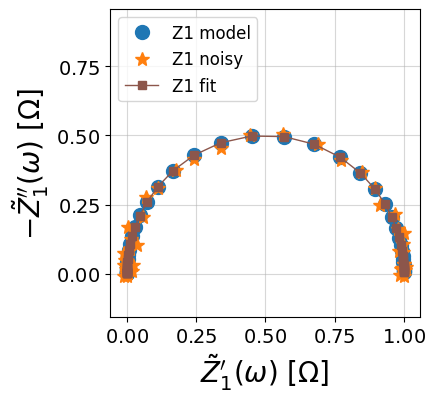

In [7]:
fig, ax = plt.subplots(figsize=(4,4))
plot_first(ax, Z1, fmt='o', ms =10)
plot_first(ax, Z1_noise, fmt='*', ms =10, color ='C1')
plot_first(ax, Z1_fit, fmt='-s', lw =1, color ='C5')
plt.legend(['Z1 model', 'Z1 noisy', 'Z1 fit'], loc=2, fontsize=12)
plt.ylim([0,0.8])
plt.show()

## 2. Using multistart_fit for NLEIS fitting with nleis.py

For this example, we will first generate a synthetic 2nd-NLEIS spectrum using `nleis.py` and add random noise to the spectrum the same way as the previous EIS example. We will then use the `multistart_fit` function from the `nleis.parallel` module to fit the noisy 2nd-NLEIS data with a complex circuit model. For demonstration purposes, we will use a circuit model with a single nonlinear RC elements.

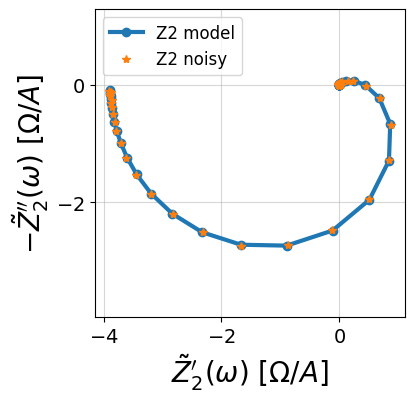

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from nleis import NLEISCustomCircuit
from nleis.visualization import plot_second


circuit_2 = "RCn0"
model_2 = NLEISCustomCircuit(circuit_2, initial_guess=[1, 1, 0.1])

f = np.geomspace(1e-3, 100, 50)
Z2 = model_2.predict(f)
Z2_noise = Z2 + 0.01*(np.random.randn(len(Z2)) + 1j*np.random.randn(len(Z2)))
fig, ax = plt.subplots(figsize=(4,4))
plot_second(ax, Z2, fmt='-o', lw =3)
plot_second(ax, Z2_noise, fmt='*', lw =1)
plt.legend(['Z2 model', 'Z2 noisy'], loc=2, fontsize=12)
plt.show()

Since we have already initialized a circuit model, we can use it directly in the `multistart_fit` function to do the fitting. But in practice, we will need to initialize a model first (i.e. `model = NLEISCustomCircuit(circuit, initial_guess=[...])`).

In this example, we demonstrate the usage of random sampling method, by setting `method = 'random'`. The `num_samples` in this case is the exact number of samples that will generated in the random sampling process. For example, `num_samples = 12` will generate 12 random starting points based on the initial guess provided (See API reference for detailed documentation).
Combining the initial guess provided, we will have a total of 13 fitting attempts. `n_jobs = -1` is selected to use all available CPU cores for parallel processing.

By default, the cost function used in `multistart_fit` is the max normalized cost function. A customized cost function can be provided via the `cost_func` argument. To demonstrate this, we use the mean absolute error as the cost function by importing `mae` from `nleis.fitting`.

In [9]:
from nleis.parallel import multistart_fit
from nleis.fitting import mae

By default, all fitting results will be printed out. This can be turned off by setting `show_results=False`.

In [10]:
best, all_runs = multistart_fit(
    model_2, f, impedance = Z2_noise, num_samples=12, sampling_method="random",
    n_jobs=-1, backend="loky", cost_func=mae, show_results=True)

{'Status': True, 'p0': array([1. , 1. , 0.1]), 'p': array([1.00026465, 1.00059568, 0.09998692]), 'cost': 0.012991704713382962, 'model': <nleis.nleis.NLEISCustomCircuit object at 0x1281f0d90>}
{'Status': True, 'p0': array([0.47392005, 0.70911467, 0.0126001 ]), 'p': array([0.81593013, 1.22664974, 0.15026821]), 'cost': 0.012991704713471752, 'model': <nleis.nleis.NLEISCustomCircuit object at 0x1234bb310>}
{'Status': True, 'p0': array([0.39391946, 0.16316159, 0.0900794 ]), 'p': array([0.94035003, 1.06434886, 0.11313421]), 'cost': 0.01299170471306237, 'model': <nleis.nleis.NLEISCustomCircuit object at 0x126207250>}
{'Status': True, 'p0': array([1.44946796, 1.97506421, 0.05016579]), 'p': array([0.99026182, 1.01070289, 0.1020171 ]), 'cost': 0.012991704713442954, 'model': <nleis.nleis.NLEISCustomCircuit object at 0x127a3e350>}
{'Status': True, 'p0': array([1.79845584, 1.63088823, 0.12931774]), 'p': array([1.19749851, 0.83579268, 0.06976267]), 'cost': 0.012991704712771987, 'model': <nleis.nleis.

After the fitting, we can easily screening all fitting results or accessing the best fit result directly.
You will also be able to see from all runs if the fitting is converged or not. After each run, the fitting status, the initial guess, final parameters, cost value, and fitted model are stored in the dictionary.

```python

In [11]:
best

{'Status': True,
 'p0': array([0.42039117, 0.85864093, 0.17157465]),
 'p': array([0.72641599, 1.37780624, 0.18958425]),
 'cost': 0.012991704711951577,
 'model': <nleis.nleis.NLEISCustomCircuit at 0x1437ba990>}

The best fit model is callable and can be used to predict the impedance at any frequency. We can then plot the original noisy data, the true model, and the fitted model for comparison.


In [12]:
Z2_fit = best['model'].predict(f)

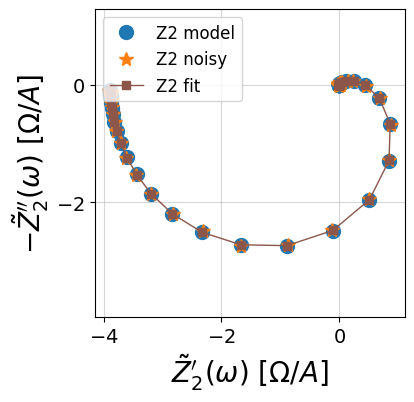

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
plot_second(ax, Z2, fmt='o', ms =10)
plot_second(ax, Z2_noise, fmt='*', ms =10, color ='C1')
plot_second(ax, Z2_fit, fmt='-s', lw =1, color ='C5')
plt.legend(['Z2 model', 'Z2 noisy', 'Z2 fit'], loc=2, fontsize=12)
# plt.ylim([0,0.8])
plt.show()

**Important Notes:** 

As one can see in this example, the parameters set that describe 2nd-NLEIS spectrum is not unique, due to the coupling of charge transfer resistance ($R_{ct}$) and charge transfer asymmetric parameter ($\varepsilon$). As a result, different initial guesses may lead to different fitting results with similar fitting quality. Therefore, it is crucial to carefully analyze the fitting results and validate them with additional experimental data or physical insights. (i.e. simultaneously fitting EIS and 2nd-NLEIS data). This also applies to EIS fitting with complex models that has multiple parameters.

If a system behaves like a RC circuit, then the charge transfer asymmetric parameter ($\varepsilon$) can be easily identified by fitting the $V_2/V_1^2$, which effectively eliminated the coupling effect of $R_{ct}$. Please refer to Eqn 11 in our original [2nd-NLEIS paper](https://iopscience.iop.org/article/10.1149/1945-7111/ad15ca/meta) for more details.

## 3. Using multistart_fit for simultaneous EIS and 2nd-NLEIS fitting with nleis.py

Simultaneous optimization of EIS and 2nd-NLEIS is probably the most efficient way to reduce the model and parameter degeneracy while analyzing complex impedance spectra like those seen in batteries. For this example, we will take the synthetic EIS and 2nd-NLEIS data we generated previously with the same underlying linear kinetics and double layer capacitance. We will then use the `multistart_fit` function from the `nleis.parallel` module to fit the noisy 2nd-NLEIS data with a complex circuit model.

For this example, we will need to initialize a model first (i.e. `model = EISandNLEIS(circuit_1,circuit_2, initial_guess=[...])`). We need to make sure we have a correct pair of EIS and 2nd-NLEIS circuit and input the correct initial_guess.

In [14]:
from nleis import EISandNLEIS

In [15]:
circuit_1 = 'RC0'
circuit_2 = 'RCn0'
model_3 = EISandNLEIS(circuit_1,circuit_2, initial_guess=[1,1,0.1])

In this example, we will demonstrate the usage of customized sampling, in which user can provide their own set of initial guesses. This can be achieved by `method = 'custom'`. We can now ignore the num_samples parameter, as it is not needed in this case. Depending on the acutal sampling provided, the total number of fitting attempts will always be +1 with the initial guess we used to initilize the model. Again, `n_jobs = -1` is selected to use all available CPU cores for parallel processing.

For simplicity, we will use the default max normalized cost function in this case.
By default, all fitting results will be printed out. This can be turned off by setting `show_results=False`.


In [16]:
initial_guesses = [[0.5, 0.5, 0.5],
                   [2, 2, 0.2],
                   [0.8, 3, 0.05]]

For the proper simultaneous analysis, we need to make sure we provide for data EIS through `Z1` and for 2nd-NLEIS through `Z2`

In [17]:
best, all_runs = multistart_fit(
    model_3, f, Z1 = Z1_noise, Z2 = Z2_noise, num_samples=12, sampling_method="custom",initial_guesses=initial_guesses,
    n_jobs=-1, backend="loky", cost_func=mae, show_results=True)

{'Status': True, 'p0': array([1. , 1. , 0.1]), 'p': array([1.00102872, 1.00018088, 0.09980643]), 'cost': 0.019120849458402214, 'model': <nleis.nleis.EISandNLEIS object at 0x1273a5c90>}
{'Status': True, 'p0': array([0.8 , 3.  , 0.05]), 'p': array([1.00102872, 1.00018088, 0.09980643]), 'cost': 0.019120849457155722, 'model': <nleis.nleis.EISandNLEIS object at 0x12777a790>}
{'Status': True, 'p0': array([2. , 2. , 0.2]), 'p': array([1.00102872, 1.00018088, 0.09980643]), 'cost': 0.01912084945840798, 'model': <nleis.nleis.EISandNLEIS object at 0x1284d8110>}
{'Status': True, 'p0': array([0.5, 0.5, 0.5]), 'p': array([1.00102872, 1.00018088, 0.09980643]), 'cost': 0.019120849458720494, 'model': <nleis.nleis.EISandNLEIS object at 0x12623bb90>}
Best fitting result: 
p0: [0.8  3.   0.05] 
p: [1.00102872 1.00018088 0.09980643] 
cost: 0.019120849457155722


After the fitting, we can easily screening all fitting results or accessing the best fit result directly.
You will also be able to see from all runs if the fitting is converged or not. After each run, the fitting status, the initial guess, final parameters, cost value, and fitted model are stored in the dictionary.

```python

In [18]:
best

{'Status': True,
 'p0': array([0.8 , 3.  , 0.05]),
 'p': array([1.00102872, 1.00018088, 0.09980643]),
 'cost': 0.019120849457155722,
 'model': <nleis.nleis.EISandNLEIS at 0x143752b50>}

As we can see here, the best fit parameters are correctly representing the parameters we inputted for simulation. The best fit model is callable and can be used to predict the impedance at any frequency. We can then plot the original noisy data, the true model, and the fitted model for comparison.

In [19]:
Z1_simul_fit,Z2_simul_fit = best['model'].predict(f)

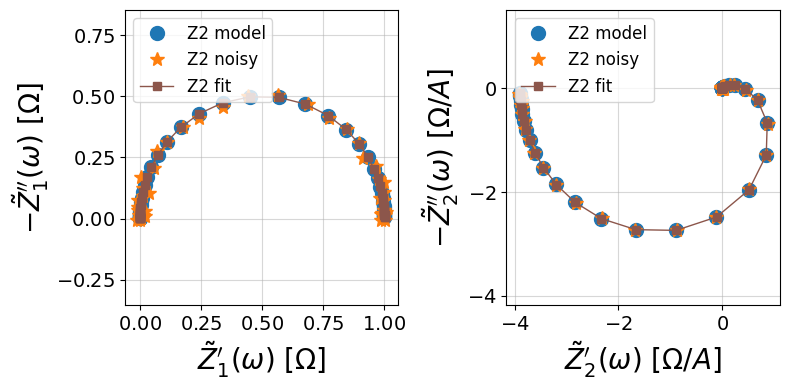

In [20]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
plot_first(ax[0], Z1, fmt='o', ms =10)
plot_first(ax[0], Z1_noise, fmt='*', ms =10, color ='C1')
plot_first(ax[0], Z1_simul_fit, fmt='-s', lw =1, color ='C5')
ax[0].legend(['Z2 model', 'Z2 noisy', 'Z2 fit'], loc=2, fontsize=12)

plot_second(ax[1], Z2, fmt='o', ms =10)
plot_second(ax[1], Z2_noise, fmt='*', ms =10, color ='C1')
plot_second(ax[1], Z2_simul_fit, fmt='-s', lw =1, color ='C5')
ax[1].legend(['Z2 model', 'Z2 noisy', 'Z2 fit'], loc=2, fontsize=12)
plt.tight_layout()
plt.show()

## Summary

In summary, `multistart_fit` can be an effective way to explore the minimization landscape and leverage the paralleizaion capability of multi-core CPU to improve the robustness of impedance analysis. However, physical fitting result is not always guaranteed, which require advanced modeling and parameter estimation strategies (i.e. the simultaneous EIS and 2nd-NLEIS analysis routine introduced here).  